In [1]:
import torch
from src.data.dataset import CNSDataset
from torch.utils.data import DataLoader
from src.descriptors import DescriptorGenerator, AVAILABLE_DESCRIPTORS

from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.swa_utils import AveragedModel, SWALR
from sklearn.metrics import fbeta_score

from IPython import display
from rich.progress import track
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.random.manual_seed(0)

In [3]:
from src.data.dataset import CNSDataset
from src.descriptors import DescriptorGenerator, AVAILABLE_DESCRIPTORS

from torch.utils.data import DataLoader, random_split

import numpy as np
TRAIN_DATASET = "dataset\mol_train.csv"
TEST_DATASET = "dataset\mol_test.csv"

whole_dataset = CNSDataset(TRAIN_DATASET, transform=DescriptorGenerator(AVAILABLE_DESCRIPTORS))
mean = torch.mean(whole_dataset._processed_data, axis=0)
std = torch.std(whole_dataset._processed_data, axis=0)
whole_dataset.standardize(mean, std)

nfeatures = whole_dataset._processed_data.shape[1]

print(f"Now the shape is {whole_dataset._processed_data.shape}")

Output()

NaN in descriptors, remove it
Now the shape is torch.Size([700, 342])


In [4]:
train, validation = random_split(
    whole_dataset,
    [0.7, 0.3],
)
batch_size = 32
train_loader = DataLoader(train, batch_size=batch_size)
validation_loader = DataLoader(validation, batch_size=len(validation))

In [5]:
model = nn.Sequential(
    nn.Linear(nfeatures, 512),
    nn.LayerNorm(512),
    nn.SiLU(),
    nn.Dropout(0.6),
    nn.Linear(512, 512),
    nn.LayerNorm(512),
    nn.SiLU(),
    nn.Dropout(0.6),
    nn.Linear(512, 128),
    nn.LayerNorm(128),
    nn.SiLU(),
    nn.Dropout(0.6),
    nn.Linear(128, 1),
    nn.Sigmoid()
)
model.to(device)
loss_fn = nn.BCELoss()
loss_fn.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-1)
scheduler = CosineAnnealingLR(optimizer, 100, eta_min=1e-10)
swa_model = AveragedModel(model)
swa_start = 1400
swa_scheduler = SWALR(optimizer, swa_lr=1e-6)

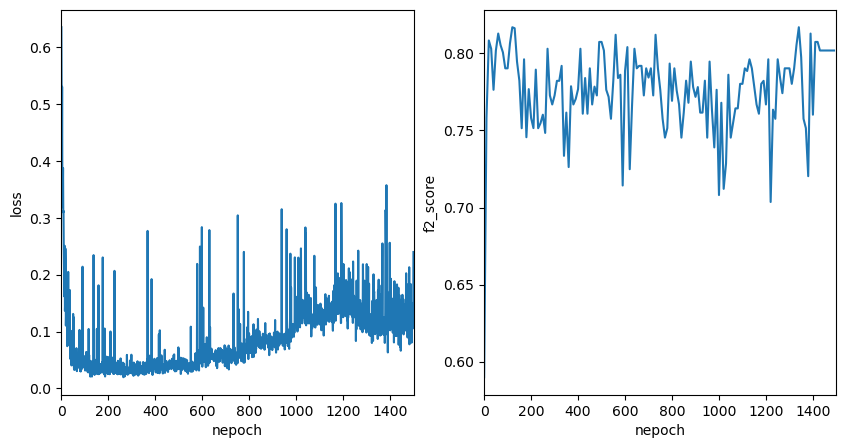

In [6]:
model.train()
train_losses = []
val_x = []
f2s = []


total_epoch = 1500
for nepoch in range(total_epoch):
    for batch in train_loader:
        y_pred = model(batch[0])
        #y_pred[y_pred > 0.5] = 1.
        #y_pred[y_pred <= 0.5] = 0.
        loss = loss_fn(y_pred, batch[1].to(device).reshape(-1, 1).float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if nepoch > swa_start:
        swa_model.update_parameters(model)
        swa_scheduler.step()
    else:
        scheduler.step()
    train_losses.append(loss.cpu().detach().numpy())
    if nepoch % 10 == 0:
        model.eval()
        val_x.append(nepoch)
        for batch in validation_loader:
            y_pred = model(batch[0])
            y_pred[y_pred > 0.5] = 1.
            y_pred[y_pred <= 0.5] = 0.
            f2s.append(fbeta_score(y_pred.detach().cpu().numpy(), batch[1], beta=2))
        model.train()
    %matplotlib inline
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(train_losses)
    ax[0].set_xlim((0, total_epoch))
    ax[0].set_xlabel("nepoch")
    ax[0].set_ylabel("loss")
    ax[1].set_xlim((0, total_epoch))
    ax[1].set_xlabel("nepoch")
    ax[1].set_ylabel("f2_score")
    ax[1].plot(val_x, f2s)

    plt.show()
    display.clear_output(wait=True)

torch.optim.swa_utils.update_bn(train_loader, swa_model)

In [8]:
model.eval()
for batch in validation_loader:
    y_pred = model(batch[0])
    y_pred[y_pred > 0.5] = 1.
    y_pred[y_pred <= 0.5] = 0.
    print(fbeta_score(y_pred.cpu().detach().numpy(), batch[1], beta=2))

0.8018867924528302


In [9]:
test = CNSDataset(TEST_DATASET, transform=DescriptorGenerator(AVAILABLE_DESCRIPTORS))
test.standardize(mean, std)

Output()

NaN in descriptors, remove it


In [11]:
model.eval()
result = model(test._processed_data).cpu().detach().numpy()

In [12]:
result[result < 0.5] = 0
result[result >= 0.5] = 1

In [13]:
result = result.astype(int)

In [14]:
result.reshape(-1)

array([0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,

In [13]:
from rdkit.Chem.rdMolDescriptors import GetFeatureInvariants
from rdkit import Chem
from rdkit.Chem import AllChem

In [14]:
mol = Chem.MolFromSmiles('CC(=O)C1(O)CCC2C3C=C(C)C4=CC(=O)CCC4(C)C3CCC12C')
molH = Chem.AddHs(mol)
AllChem.EmbedMolecule(molH)

0

In [15]:
a = GetFeatureInvariants(molH)

In [16]:
len(a)

55

In [17]:
a

[0,
 0,
 2,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [34]:
[int(item) for item in list(a.ToBinary())]

[1,
 0,
 0,
 0,
 8,
 0,
 0,
 0,
 0,
 16,
 0,
 0,
 0,
 0,
 0,
 0,
 55,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 68,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 71,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 83,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 168,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 145,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 146,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 200,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 93,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 94,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 35,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 44,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 46,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 105,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 181,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 72,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 115,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 163,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 213,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 236,
 5,
 

In [35]:
len([int(item) for item in list(a.ToBinary())])

684